In [49]:
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn.cluster import DBSCAN
from matplotlib.pyplot import *
from plotly.offline import plot, iplot

import warnings
warnings.filterwarnings('ignore')

In [50]:
df = pd.read_csv('Desktop/speed.csv')

date = pd.to_datetime(df.timestamp)#, format="%y/%m/%d %H:%M:%S")
index = pd.DatetimeIndex(df.timestamp)
ser = pd.Series(df.value, dtype='float64')
print("Date: ",df.timestamp.dtype)
print("index: ", index.dtype)

Date:  object
index:  datetime64[ns]


In [51]:
data = pd.DataFrame(zip(index, ser))
data=data.rename(columns={0: "Date", 1: "Speed"})
data = data.set_index('Date')
print(data)
#data = data.to_excel('Desktop/output.xlsx') 

                     Speed
Date                      
2015-08-31 18:22:00   90.0
2015-08-31 18:32:00   80.0
2015-08-31 18:57:00   84.0
2015-08-31 19:07:00   94.0
2015-08-31 19:12:00   90.0
...                    ...
2015-09-17 16:04:00   81.0
2015-09-17 16:09:00   89.0
2015-09-17 16:14:00   87.0
2015-09-17 16:19:00   82.0
2015-09-17 16:24:00   83.0

[2500 rows x 1 columns]


In [52]:
#So far I have done what I did in the last lab -- loaded in the data set, and converted the date to datetime in
#order to be able to graph in on the X axis and the Y values into float 

In [53]:
print('Minimum speed: ' + str(data['Speed'].min()))
print('Maximum speed: ' + str(data['Speed'].max()))
print("Avg speed: ",data.Speed.mean())

Minimum speed: 20.0
Maximum speed: 109.0
Avg speed:  81.9068


In [54]:
#Here I am just checking the min, max and mean since they could be important

Text(0.5, 1.0, 'Recorded Speeds, 8/31-9/18')

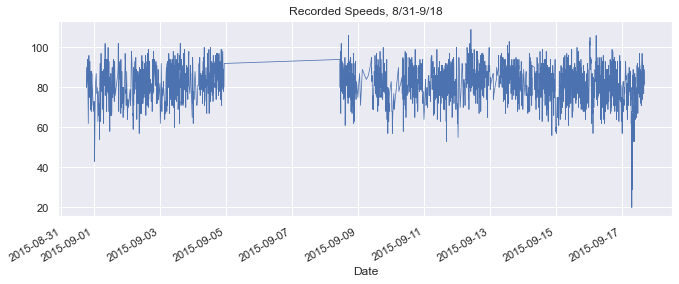

In [56]:
sns.set(rc={'figure.figsize':(11, 4)})
data['Speed'].plot(linewidth=0.75,label='Speed over time');
plt.title('Recorded Speeds, 8/31-9/18')

In [10]:
#Above: initial graph of data, no anamoly detection

                    Date  Speed  Above_Avg
0    2015-08-31 18:22:00   90.0       True
1    2015-08-31 18:32:00   80.0      False
2    2015-08-31 18:57:00   84.0       True
3    2015-08-31 19:07:00   94.0       True
4    2015-08-31 19:12:00   90.0       True
...                  ...    ...        ...
2495 2015-09-17 16:04:00   81.0      False
2496 2015-09-17 16:09:00   89.0       True
2497 2015-09-17 16:14:00   87.0       True
2498 2015-09-17 16:19:00   82.0       True
2499 2015-09-17 16:24:00   83.0       True

[2500 rows x 3 columns]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

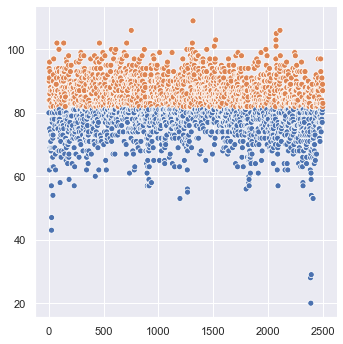

In [11]:
data = data.reset_index()
data["Above_Avg"] = data["Speed"] > (data.Speed.mean())
print(data)
sns.relplot(data=data, x=data.index,y=data.Speed, hue="Above_Avg")

In [12]:
#My initial thoughts were to use the average speed to determine (and experiment with the color of a graph)
#which are above and below the average speed. I can improve on this though; see below 
#Another issue is the date, obviously, the x is based on the index of the data, 0-2500

0       True
1       True
2       True
3       True
4       True
        ... 
2495    True
2496    True
2497    True
2498    True
2499    True
Name: Not_outlier, Length: 2500, dtype: bool


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

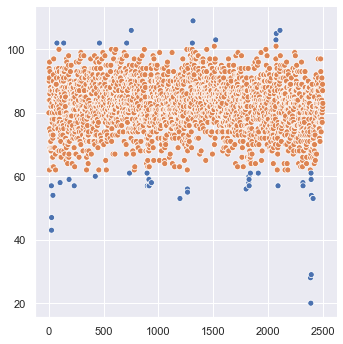

In [13]:
data["Not_outlier"] = ((data["Speed"] < (data.Speed.mean()+20))& (data["Speed"] > (data.Speed.mean()-20)))
print(data.Not_outlier)
sns.relplot(data=data, x=data.index,y=data.Speed, hue="Not_outlier")

In [14]:
#I created a new column that holds a true or false value based on whether the Speed value is a certain threshold
#away from the average speed, and using that true/false value to shade the graph accordingly
#Though this is a good start and initial visualiation of what the outliers are/might be, I should implement 
#1. a function that actually alogorthmically determines the outliers and 2. do so in a way that I'm not
#getting a ValueError

In [31]:
from sklearn.ensemble import IsolationForest

clf=IsolationForest(n_estimators=10, contamination=float(.05),max_features=1.0, n_jobs=-1, random_state=42)
clf.fit(df[['value']])
df['anomaly']=clf.predict(df[['value']])
df.loc[df['anomaly'] == 1,'anomaly'] = 0
df.loc[df['anomaly'] == -1,'anomaly'] = 1
print(df.anomaly)
df.anomaly.value_counts()

0       0
1       0
2       0
3       0
4       0
       ..
2495    0
2496    0
2497    0
2498    0
2499    0
Name: anomaly, Length: 2500, dtype: int64


0    2384
1     116
Name: anomaly, dtype: int64

In [17]:
#using Isolation forest, the anomalies generated are determined by the clf.predict(); I chose 
#the contamination factor to be 5% because that seemed fitting 
#value_counts() shows us how many speed values were determined to be an anomaly and which are not, represented
#by a 1 or -1 until it is changed to be a 0 or 1 

In [46]:
def plot_anomaly(df,name):
    df.timestamp = pd.to_datetime(df['timestamp'].astype(str), format="%Y-%m-%d %H:%M:%S")
    #df.truncate(before=('2015-09-05'),after=('2015-09-07'))
    dates = df.timestamp
    
    bool_array = ((df['anomaly']) > 0)
    actuals = df["value"]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 0] = np.nan

    Actuals = go.Scatter(name='Recorded Speeds', x=dates,y=df['value'],xaxis='x1', yaxis='y1',mode='markers',
                     marker=dict(size=5,line=dict(width=1),color="blue"))
    
    Actuals2 = go.Scatter(name="trace", x=dates,y=df['value'],xaxis='x1', yaxis='y1',mode='lines',
                 marker=dict(size=.1,line=dict(width=1),color="blue"))

    anomalies_map = go.Scatter(name="Anomaly",showlegend=True,x=dates,y=anomaly_points,mode='markers',xaxis='x1',yaxis='y1',
                               marker=dict(color="red",size=7,line=dict(color="red",width=2)))
    
    axis = dict(showgrid=True)
    layout = dict(width=1500,height=800,title="Speed Anomalies",showlegend=True)
    fig = go.Figure(data=[Actuals2,Actuals,anomalies_map], layout=layout)
    iplot(fig)
    plt.show()
plot_anomaly(df,'anomalies')


In [33]:
#the plot_anomlay function plots 3 seperate scatter plots and graphs them -- I chose to plot the Actuals as both
#the markers, but i thought the line was also important to see the time progression of the data.
#The red markers represent the found anomalies, which was graphed by 1. finding which data in the anomalies 
#column was >1 and then, by multiplying it by the speed, lets say it was 109, the 1*109 then plots it in the correct
#row and column, the anomalies that are 0 need to be dropped/nan so it doesnt graph a giant red line at the bottom

#the use of iplot and go. has changed my life, hah. You can see the data points info, as well as zoom in over a range. 
#It's awesome 

In [34]:
color_map = {0: "lightblue", 1: "red"}
table = go.Table(header=dict(height=2,values=[['Date</b>'], ['Speeds </b>']],fill=dict(color='white')),
cells=dict(values=[df.round(3)[k].tolist() for k in ['timestamp', 'value']],line=dict(color='black'),height=25,fill=dict(color=[df['anomaly'].map(color_map)])))
layout = dict(title="Table of Speed Anomalies")
fig = go.Figure(data=[table], layout=layout)
iplot(fig)
plt.show()

In [35]:
#Heres a cool feature that I really liked -- it shows all the data, and which as considered anomalies, by highlighting 
#it in red. I think this is important because even with the grid, 2500 data points is hard to read. 

In [36]:
print("Total anomalies: ",(len(df.loc[df['anomaly']==1])))
print("out of: ",(len(df)))
print("Percentage of anomalies: {:.2f}".format((len(df.loc[df['anomaly']==1])/len(df))*100))

Total anomalies:  116
out of:  2500
Percentage of anomalies: 4.64


In [ ]:
# Lastly, here is just an output that shows the percentage of total anomalies, as expected 4.6% of this dataset is
#considered an anomaly, which is based on the contamination factor, which I set to 5%